<a href="https://colab.research.google.com/github/aramakrishnan-006/pytorch-notebooks/blob/main/pytorch_simple_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

In [25]:
#Generate Synthetic Data

N = 2000

series = np.sin(0.1*np.arange(N)) + np.random.randn(N) * 0.1

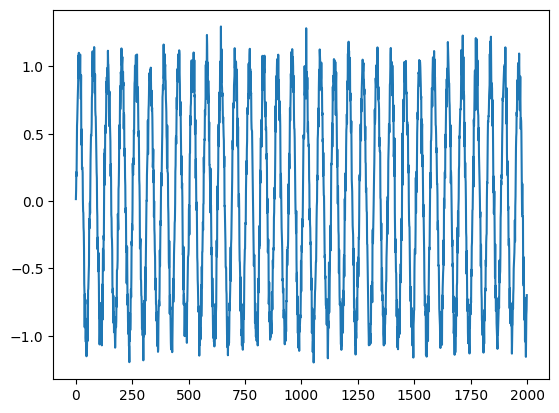

In [26]:
#Plot the data
plt.plot(series)
plt.show()

In [27]:
#Using the previous 20 values to predict the next
T = 20 #Looking back 20 values
X = []
Y = []

for t in range(len(series) - T):
  x = series[t:t+T]
  X.append(x)

  y = series[t+T]
  Y.append(y)

#This is different from the AR model; X needs to be of 3-D
#The shape is of NxTxD where D = 1
X = np.array(X).reshape(-1, T, 1)
Y = np.array(Y).reshape(-1, 1)

N = len(X)

print(f'X.Shape: {X.shape} Y.shape: {Y.shape}')


X.Shape: (1980, 20, 1) Y.shape: (1980, 1)


In [28]:
#Setting Device to GPU if it is available
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [29]:
#Define a SimpleRNN
class SimpleRNN(nn.Module):
  def __init__(self, n_inputs, n_hidden, n_rnnlayers, n_outputs):
    super(SimpleRNN, self).__init__()
    self.D = n_inputs
    self.M = n_hidden
    self.K = n_outputs
    self.L = n_rnnlayers

    #If batch first is set to True, then the shape will be
    #(num of samples, sequence length and number of features)
    #or else
    #(sequence length, number of samples and number of features)

    self.rnn = nn.RNN(
        input_size = self.D,
        hidden_size = self.M,
        num_layers = self.L,
        nonlinearity = 'relu',
        batch_first = True
    )
    self.fc = nn.Linear(self.M, self.K)

  def forward(self, X):
    h0 = torch.zeros(self.L, X.size(0), self.M).to(device)

    #get the output of the RNN unit; Size is NxTxM
    #The _ is to capture the hidden state at the hidden layer. We don't use this
    out, _ = self.rnn(X, h0)

    #Output at the final layer
    # NxM => NxK
    out = self.fc(out[:, -1, :])
    return out

In [30]:
#Building the Model
model = SimpleRNN(n_inputs = 1, n_hidden = 5, n_rnnlayers=1, n_outputs=1)
model.to(device)

SimpleRNN(
  (rnn): RNN(1, 5, batch_first=True)
  (fc): Linear(in_features=5, out_features=1, bias=True)
)

In [31]:
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

In [32]:
#Getting the training and test sets
X_train = torch.from_numpy(X[:N//2].astype(np.float32))
X_test = torch.from_numpy(X[-N//2:].astype(np.float32))
y_train = torch.from_numpy(Y[:N//2].astype(np.float32))
y_test = torch.from_numpy(Y[-N//2:].astype(np.float32))

In [33]:
#Move data to GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

In [34]:
#Training

def full_gradientDescent(model, optimizer, criterion, X_train, y_train, X_test, y_test, epochs=200):
  train_losses = np.zeros(epochs)
  test_losses = np.zeros(epochs)

  for i in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)

    loss.backward()
    optimizer.step()

    #Save Training Losses
    train_losses[i] = loss.item()

    #Test Losses
    test_outputs = model(X_test)
    test_loss = criterion(test_outputs, y_test)
    test_losses[i] = test_loss.item()

    if (i + 1) % 10 ==0:
      print(f"Epoch {i + 1}/{epochs} Train Loss: {loss.item():.4f} Test Loss: {test_loss.item():.4f}")

  return train_losses, test_losses


In [42]:
train_losses, test_losses = full_gradientDescent(model, optimizer, criterion, X_train, y_train, X_test, y_test, 300)

Epoch 10/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 20/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 30/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 40/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 50/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 60/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 70/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 80/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 90/300 Train Loss: 0.0242 Test Loss: 0.0246
Epoch 100/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 110/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 120/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 130/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 140/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 150/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 160/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 170/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 180/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 190/300 Train Loss: 0.0241 Test Loss: 0.0246
Epoch 200/300 Train Loss: 0.0241 Test Lo

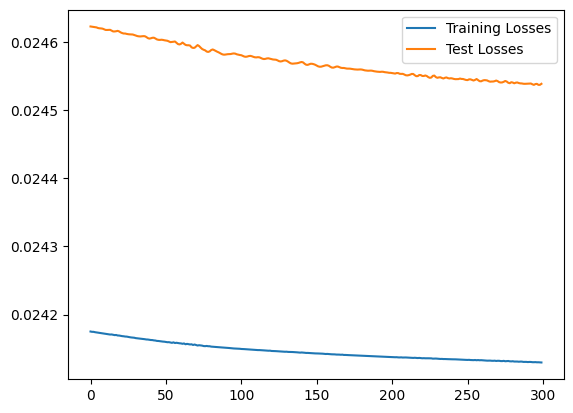

In [43]:
plt.plot(train_losses, label='Training Losses')
plt.plot(test_losses, label = 'Test Losses')
plt.legend()
plt.show()

In [44]:

#Forecasting

#Gone Wrong

validation_targets = Y[-N//2:]
validation_predictions = []

i = 0

while len(validation_predictions) < len(validation_targets):
  input = X_test[i].view(1, T, -1)
  p = model(input)[0,0].item() #convert array to scalar
  i += 1

  #append the predictions
  validation_predictions.append(p)

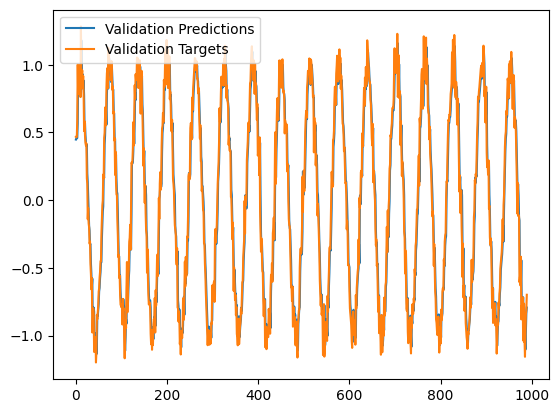

In [45]:
plt.plot(validation_predictions, label = 'Validation Predictions')
plt.plot(validation_targets, label='Validation Targets')
plt.legend()
plt.show()

In [46]:
#Forecast

#Corrections

validation_targets = Y[-N//2:]
validation_predictions = []

#last_x = torch.from_numpy(X[-N//2].astype(np.float32))
last_x = X_test[0].view(T)

while len(validation_predictions) < len(validation_targets):
  input = last_x.view(1, T, -1)
  p = model(input)

  #append the predictions
  validation_predictions.append(p[0,0].item())

  last_x = torch.cat((last_x[1:], p[0]))

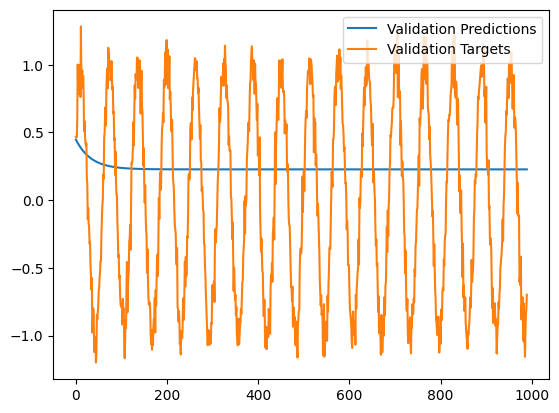

In [47]:

plt.plot(validation_predictions, label = 'Validation Predictions')
plt.plot(validation_targets, label='Validation Targets')
plt.legend()
plt.show()